ChEn-3170: Computational Methods in Chemical Engineering Spring 2024 UMass Lowell; Prof. V. F. de Almeida **18Mar24**

# 08. Full-Rank Least-Squares Reaction Rates
$  
  \newcommand{\Amtrx}{\boldsymbol{\mathsf{A}}}
  \newcommand{\Bmtrx}{\boldsymbol{\mathsf{B}}}
  \newcommand{\Mmtrx}{\boldsymbol{\mathsf{M}}}
  \newcommand{\Imtrx}{\boldsymbol{\mathsf{I}}}
  \newcommand{\Pmtrx}{\boldsymbol{\mathsf{P}}}
  \newcommand{\Lmtrx}{\boldsymbol{\mathsf{L}}}
  \newcommand{\Umtrx}{\boldsymbol{\mathsf{U}}}
  \newcommand{\Smtrx}{\boldsymbol{\mathsf{S}}}
  \newcommand{\xvec}{\boldsymbol{\mathsf{x}}}
  \newcommand{\avec}{\boldsymbol{\mathsf{a}}}
  \newcommand{\bvec}{\boldsymbol{\mathsf{b}}}
  \newcommand{\cvec}{\boldsymbol{\mathsf{c}}}
  \newcommand{\rvec}{\boldsymbol{\mathsf{r}}}
  \newcommand{\mvec}{\boldsymbol{\mathsf{m}}}
  \newcommand{\gvec}{\boldsymbol{\mathsf{g}}}
  \newcommand{\zerovec}{\boldsymbol{\mathsf{0}}}
  \newcommand{\norm}[1]{\bigl\lVert{#1}\bigr\rVert}
  \newcommand{\transpose}[1]{{#1}^\top}
  \DeclareMathOperator{\rank}{rank}
$

---
## Table of Contents<a id="toc">
* [Introduction](#intro)
* [Full-Rank Reaction mechanism](#rxnmech)
* [Full-Rank Least-Squares Reaction Rates](#lsr)
    - [Random Production Rates](#randomg)
    - [Realistic Production Rates](#realg)
    - [How to build a solve wrapper function](#solve)
---

## [Introduction](#toc)<a id="intro"></a>

Recall course notes OneNote [ChEn-3170-stoic](https://studentuml-my.sharepoint.com/:o:/g/personal/valmor_dealmeida_uml_edu/ErP_geWv9B9Au69BmR9ECSMBrZaUdSwJBIx6AXjiX7mMfA?e=aMCnDm) on computational stoichiometry including an introduction to the linear, full-rank, least-squares method.

This topic is an application of the least-squares method for calculating *net* reaction rates.
The relation between the (instantaneous) *net* reaction rates vector, $\rvec$, and the (instantaneous) species production rates vector, $\gvec$, is given by $\transpose{\Smtrx}\,\rvec = \gvec$. Since this is often a rectangular system, it remains the problem of finding a *solution*. Specifically if $\Smtrx$ is $m \times n$ with $m$ reactions and $n$ species, then $\Smtrx^\top$ is $n\times m$, that is,

$\Smtrx^\top = 
\begin{pmatrix}
S^\top _{1,1} & S^\top _{1,2} & \dots  & S^\top _{1,m} \\
S^\top _{2,1} & S^\top _{2,2} & \dots  & S^\top _{2,m} \\
\vdots  & \vdots  & \ddots & \vdots \\
S^\top _{n,1} & S^\top _{n,2} & \dots  & S^\top _{n,m}
\end{pmatrix} 
$
where $S^\top_{i,j} = S_{j,i}$. 

The reaction rates and species production rates are related by the matrix product

\begin{equation*}
\begin{pmatrix}
S^\top _{1,1} & S^\top _{1,2} & \dots  & S^\top _{1,m} \\
S^\top _{2,1} & S^\top _{2,2} & \dots  & S^\top _{2,m} \\
\vdots  & \vdots  & \ddots & \vdots \\
S^\top _{n,1} & S^\top _{n,2} & \dots  & S^\top _{n,m}
\end{pmatrix} 
\,
\begin{pmatrix}
r_1 \\ 
r_2 \\ 
\vdots  \\ 
r_m 
\end{pmatrix}
=
\begin{pmatrix}
g_1 \\ 
g_2 \\ 
\vdots  \\ 
g_n 
\end{pmatrix}
\end{equation*}

which shows that each species production rate has a contribution of every reaction:

\begin{equation*}
g_j = \sum\limits_{i=1}^m S^\top _{j,i}\, r_i = \Smtrx^\top_{j,\bullet}\cdot\rvec = \Smtrx_{\bullet,j}\cdot\rvec  \qquad\  \forall \qquad\  j=1,\ldots, n.
\end{equation*}

Refer to the course notes OneNote [ChEn-3170-stoic](https://studentuml-my.sharepoint.com/:o:/g/personal/valmor_dealmeida_uml_edu/ErP_geWv9B9Au69BmR9ECSMBrZaUdSwJBIx6AXjiX7mMfA?e=aMCnDm) on computational stoichiometry including an introduction to the linear, full-rank, least-squares method.

To compute the reaction rates vector $\rvec$ for a given species production vector $\gvec$ we need to solve:

\begin{equation*}
\Smtrx^\top\,\rvec = \gvec .
\end{equation*}

There exists a **unique** least-squares solution $\rvec_\text{LS}$ to this problem if $\Smtrx$ is full rank, that is,

\begin{equation*}
 \min\limits_\rvec \norm{\gvec - \Smtrx^\top\,\rvec_\text{LS}}^2 \quad\  \forall \quad\ \rvec.
\end{equation*}

This solution is obtained by solving:

\begin{equation*}
\Smtrx\,\Smtrx^\top\,\rvec_\text{LS}  = \Smtrx\,\gvec ,
\end{equation*}

where $\Smtrx\,\Smtrx^\top$ is square, symmetric, and non-singular. The least-squares problem is just $\Amtrx\,\xvec=\bvec$ with
$\Amtrx = \Smtrx\,\Smtrx^\top$ and $\bvec = \Smtrx\,\gvec$. The $\Amtrx$ is called, the normal matrix.

Once the **unique** LS net reaction rates $\rvec_\text{LS}$ are computed, they can be used to fit reaction rate constants $k_{\text{f}i}$ and $k_{\text{b}i}$ (forward and backward, respectively) to experimental data using the reaction rates expressions

\begin{equation*}
 r_{\text{LS}i} = k_{\text{f}i}\prod\limits_{j=1}^n\,c_j^{\alpha_{i,j}} - k_{\text{b}i}\prod\limits_{j=1}^n\,c_j^{\beta_{i,j}} 
 \quad\ \forall \quad\ i=1,\ldots,m ,
\end{equation*}

as function of the concentration of the species $c_j(t)$. The exponents $\alpha_{i,j}$ are values determined by experiments for the dependency of the forward rates of reaction on all species concentrations. Similarly $\beta_{i,j}$ are the counterparts for the backward rates of reaction. These exponent coefficients are related to the stoichiometric coefficients $S_{i,j}$ so that $\alpha_{i,j}\,S_{i,j} \le 0$ and $\beta_{i,j}\,S_{i,j} \ge 0$. The values of $\alpha_{i,j}$ and $\beta_{i,j}$ are not necessarily the same as $S_{i,j}$. These values are determined experimentally and the resulting rate expression is typically called the rate law.

## [Full-Rank Reaction Mechanism](#toc)<a id="rxnmech"></a>
Refer to course Notebook 07 for assembling the stoichiometric matrix.

In [1]:
'''Read a reaction mechanism and create data structures'''

# build the stoichiometric matrix
try:    
    from chen_3170.toolkit import reaction_mechanism 
except ModuleNotFoundError:
    assert False, 'You need to provide your own reaction_mechanism function here. Bailing out.'

(species, reactions, stoic_mtrx, rxn_mech) = reaction_mechanism('data/methane-catalyst-rxn.txt')

print(species)
print('# of species =',len(species))
print('')
from chen_3170.help import print_reactions

print_reactions(reactions)

['C(s)', 'CH(s)', 'CH2(s)', 'CH3(s)', 'CH4(g)', 'CO(g)', 'CO(s)', 'H(s)', 'H2(g)', 'H2O(g)', 'O(s)', 'S']
# of species = 12

r0 :  CO(g)  + S     <=> CO(s)
r1 :  CO(s)  + S     <=> C(s)   + O(s)
r2 :  O(s)   + H2(g) <=> H2O(g) + S
r3 :  H2(g)  + 2 S   <=> 2 H(s)
r4 :  C(s)   + H(s)  <=> CH(s)  + S
r5 :  CH(s)  + H(s)  <=> CH2(s) + S
r6 :  CH2(s) + H(s)  <=> CH3(s) + S
r7 :  CH3(s) + H(s)  <=> CH4(g) + 2 S
n_reactions = 8


matrix shape = (8, 12)


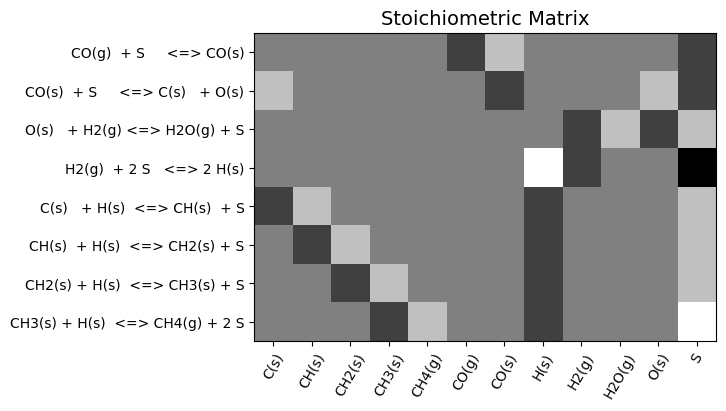

stoic_mtrx=
 [[ 0.  0.  0.  0.  0. -1.  1.  0.  0.  0.  0. -1.]
 [ 1.  0.  0.  0.  0.  0. -1.  0.  0.  0.  1. -1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0. -1.  1. -1.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  2. -1.  0.  0. -2.]
 [-1.  1.  0.  0.  0.  0.  0. -1.  0.  0.  0.  1.]
 [ 0. -1.  1.  0.  0.  0.  0. -1.  0.  0.  0.  1.]
 [ 0.  0. -1.  1.  0.  0.  0. -1.  0.  0.  0.  1.]
 [ 0.  0.  0. -1.  1.  0.  0. -1.  0.  0.  0.  2.]]

mole balance vector =
 [-1.  0.  0. -1.  0.  0.  0.  1.]


In [2]:
'''Check the stoichiometric matrix'''

from chen_3170.help import plot_matrix

plot_matrix(stoic_mtrx, title='Stoichiometric Matrix', color_map='gray', xlabels=species, ylabels=reactions)
print('stoic_mtrx=\n',stoic_mtrx)
print('')
print('mole balance vector =\n', stoic_mtrx.sum(1))

In [3]:
'''Rank of S'''

try:    
    from chen_3170.toolkit import matrix_rank   
except ModuleNotFoundError:
    assert False, 'You need to provide your own matrix_rank function here. Bailing out.'

s_rank = matrix_rank(stoic_mtrx)
# s_rank = np.linalg.matrix_rank(stoic_mtrx) # use numpy for the moment if your matrix_rank does not work
print('S shape   = ',stoic_mtrx.shape)
print('Rank of S = ',s_rank)

if s_rank == min(stoic_mtrx.shape):
    print('Matrix is full rank.')
else:
    print('Matrix is rank deficient.')

S shape   =  (8, 12)
Rank of S =  8
Matrix is full rank.


## [Full-Rank Least-Squares Reaction Rates](#toc)<a id="lsr"></a>
Refer to course Notebook 07.

### [Random Production Rates](#toc)<a id="randomg"></a>

In [4]:
'''Assume a species production rate as random'''

import numpy as np
a = -1.8
b =  2.1
g_vec = (b-a)*np.random.random(len(species)) + a

Here, let's compute $\rvec_\text{LS} $ for 
$
\Smtrx\,\Smtrx^\top\,\rvec_\text{LS}   = \Smtrx\,\gvec .
$

In [5]:
'''Compute the LS reaction rates for random species production rates'''

# make sure the matrix is full rank

try:    
    from chen_3170.toolkit import matrix_rank   
except ModuleNotFoundError:
    assert False, 'You need to provide your own matrxi_rank function here. Bailing out.'
    
assert matrix_rank(stoic_mtrx) == min(stoic_mtrx.shape[0],stoic_mtrx.shape[1])
assert matrix_rank(stoic_mtrx) < stoic_mtrx.shape[1]
assert matrix_rank(stoic_mtrx) == np.linalg.matrix_rank(stoic_mtrx)

# build A x = b for the LS problem
a_mtrx = stoic_mtrx @ stoic_mtrx.transpose() # A = S ST, A is the normal matrix (or Gram matrix)
b_vec  = stoic_mtrx @ g_vec                  # b = S g

try:    
    from chen_3170.toolkit import lu_factorization   
except ModuleNotFoundError:
    assert False, 'You need to provide your own lu_factorization function here. Bailing out.'

# matrix LU factorization of A, the normal matrix
(L, U, P, _) = lu_factorization(a_mtrx, 'partial') # matrix is full rank; partial pivoting works

from chen_3170.help import forward_solve

try:    
    from chen_3170.toolkit import backward_solve   
except ModuleNotFoundError:
    assert False, 'You need to provide your own backward_solve function here. Bailing out.'

# solve the LS problem: A x = b
y_vec = forward_solve(L, P@b_vec)   # L y = P b
x_vec = backward_solve(U, y_vec)      # U x = y

assert np.linalg.norm(x_vec - np.linalg.solve(a_mtrx,b_vec)) < 1e-12

np.set_printoptions(precision=3,threshold=100,edgeitems=3)
print('species = ',species)
print('species production rates g_vec =', g_vec)

r_vec = x_vec # r = x
print('reaction rates r_vec =', r_vec)
residual_vec = g_vec - stoic_mtrx.transpose() @ r_vec
print('residual norm ||g - ST r|| = %8.5e'%np.linalg.norm(residual_vec))

species =  ['C(s)', 'CH(s)', 'CH2(s)', 'CH3(s)', 'CH4(g)', 'CO(g)', 'CO(s)', 'H(s)', 'H2(g)', 'H2O(g)', 'O(s)', 'S']
species production rates g_vec = [-0.149  0.762 -0.051  0.074 -0.098  1.02  -1.083  0.558  0.036 -1.096
  1.569  1.243]
reaction rates r_vec = [-1.298  0.094 -0.924  0.751  0.586  0.099  0.356  0.419]
residual norm ||g - ST r|| = 1.28711e+00


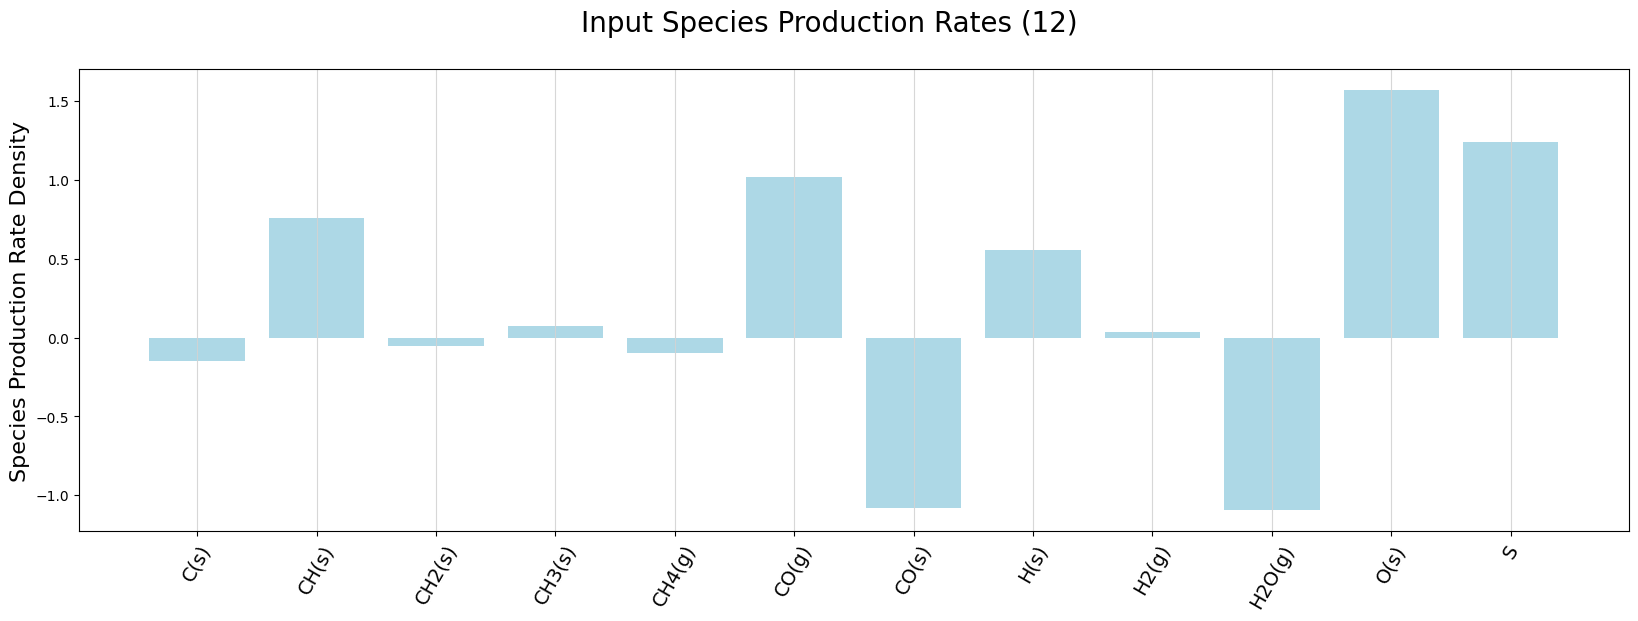

species =  ['C(s)', 'CH(s)', 'CH2(s)', 'CH3(s)', 'CH4(g)', 'CO(g)', 'CO(s)', 'H(s)', 'H2(g)', 'H2O(g)', 'O(s)', 'S']
species production rates g_vec = [-0.149  0.762 -0.051  0.074 -0.098  1.02  -1.083  0.558  0.036 -1.096
  1.569  1.243]


In [6]:
'''Plot of the input species production rate'''

try: 
    from chen_3170.toolkit import plot_rates   
except ModuleNotFoundError:
    assert False, 'You need to provide your plot_rates function here. Bailing out.'
#%matplotlib inline
plot_rates(species, g_vec, 
           title='Input Species Production Rates ('+str(len(species))+')', 
           y_label='Species Production Rate Density', 
           x_tick_rotation=60, bar_color='lightblue', style='default')

print('species = ',species)
print('species production rates g_vec =',g_vec)

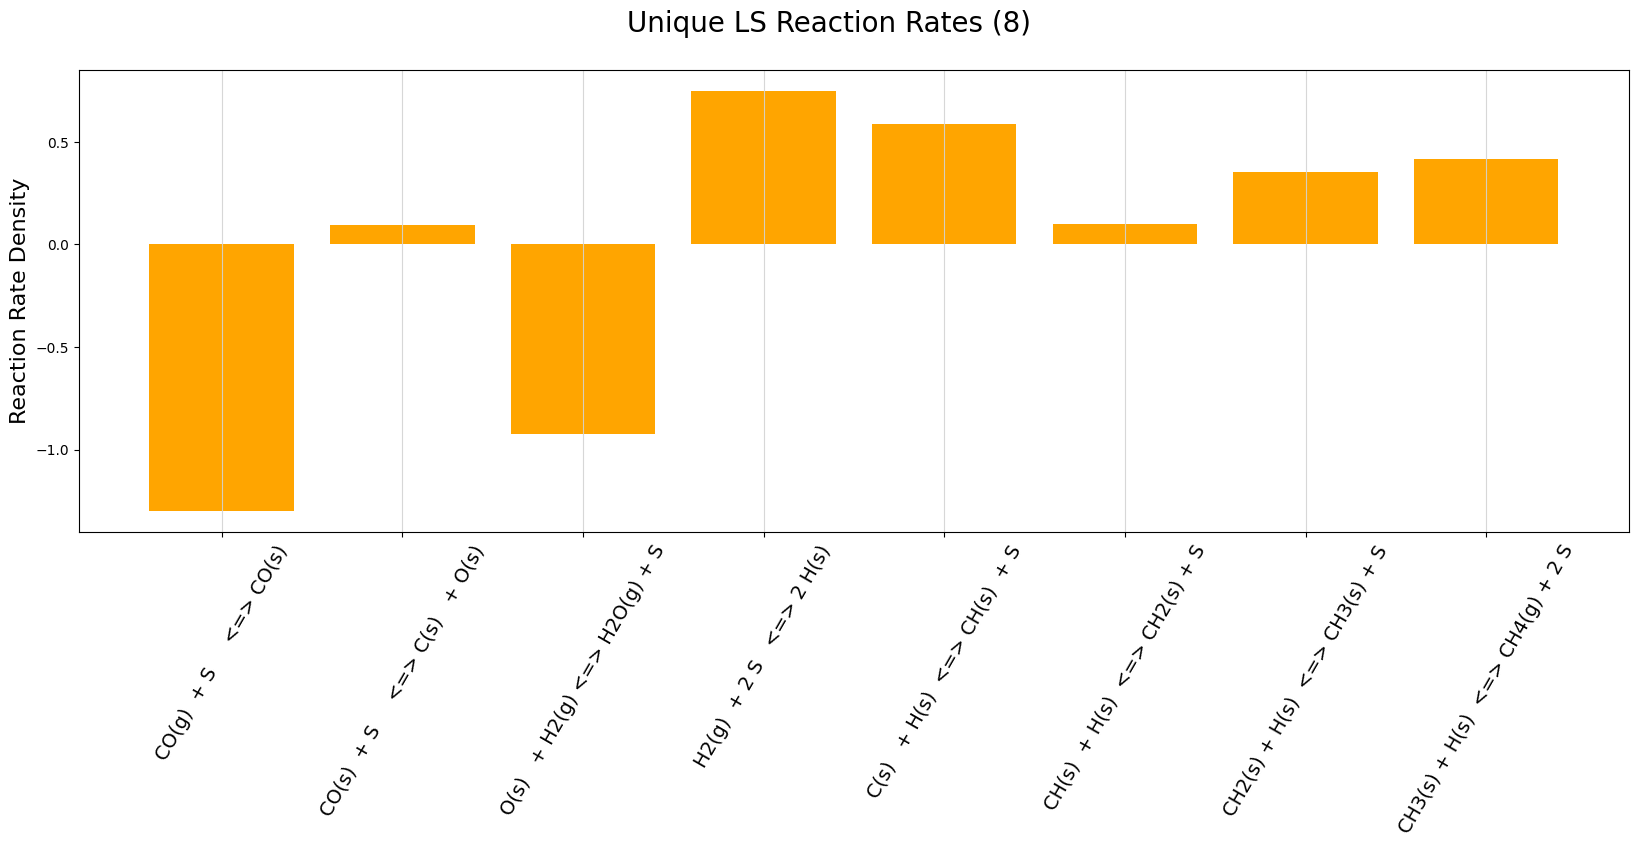

reaction rates r_vec = [-1.298  0.094 -0.924  0.751  0.586  0.099  0.356  0.419]


In [7]:
'''Plot least-squares reaction rates'''

try: 
    from chen_3170.toolkit import plot_rates   
except ModuleNotFoundError:
    assert False, 'You need to provide your plot_rates function here. Bailing out.'
%matplotlib inline   
plot_rates(reactions, r_vec, 
           title='Unique LS Reaction Rates (%s)'%str(s_rank), 
           y_label='Reaction Rate Density', 
           x_tick_rotation=60, bar_color='orange', style='default')

print('reaction rates r_vec =',r_vec)

### [Realistic Production Rates](#toc)<a id="realg"></a>

In [8]:
'''Assume the following species production rate'''

g_dict = dict()

g_dict['CH4(g)'] = -2.9
g_dict['O(s)']   = -4.1
g_dict['S']      = 0.4
g_dict['CO(s)']  = 0.3
g_dict['H2O(g)'] = 2.7
g_dict['C(s)']   = 1.3
g_dict['CO(g)']  = 1.1
g_dict['H(s)']   = 1.9
g_dict['CH3(s)'] = 1.1
g_dict['CH2(s)'] = -1.3
g_dict['H2(g)']  = 1.6
g_dict['CH(s)']  = 0.4

for spc in species:
    g_vec[species.index(spc)] = g_dict[spc]

### [How to build a solve wrapper function](#toc)<a id="solve"></a>

To improve code reuse, creating a solve function can expedite problem solving. This is described next.

In [13]:
'''Solve Wrapper Function'''
try:    
    from chen_3170.toolkit import lu_factorization   
except ModuleNotFoundError:
    assert False, 'You need to provide your own lu_factorization function here. Bailing out.'
    
from chen_3170.help import forward_solve 
try:    
    from chen_3170.toolkit import backward_solve   
except ModuleNotFoundError:
    assert False, 'You need to provide your own backward_solve function here. Bailing out.'

def solve(a_mtrx, b_vec, pivoting_option='partial', pivot_tol=1e-8, zero_tol=1e-12):
    # matrix LU factorization of A, the normal matrix
    (L, U, P, _) = lu_factorization(a_mtrx, pivoting_option=pivoting_option, pivot_tol=pivot_tol) # matrix is full rank; partial pivoting works
    assert matrix_rank(stoic_mtrx) == np.linalg.matrix_rank(stoic_mtrx)
    
    # solve the LS problem: A x = b
    y_vec = forward_solve(L, P @ b_vec)   # L y = P b
    x_vec = backward_solve(U, y_vec, diag_tol=pivot_tol, zero_tol=zero_tol)   # U x = y
    assert np.linalg.norm(x_vec - np.linalg.solve(a_mtrx,b_vec)) < 1e-12
    
    return x_vec

In [14]:
'''Compute the LS reaction rates for random species production rates'''

# build A x = b for the LS problem
a_mtrx = stoic_mtrx @ stoic_mtrx.transpose() # A = S ST, A is the normal matrix
b_vec  = stoic_mtrx @ g_vec                  # b = S g

r_vec = solve(a_mtrx, b_vec)

np.set_printoptions(precision=3,threshold=100,edgeitems=3)
print('species = ',species)
print('species production rates g_vec =',g_vec)

print('reaction rates r_vec =',r_vec)
residual_vec = g_vec - stoic_mtrx.transpose() @ r_vec
print('residual norm ||g - ST r|| = %8.5e'%np.linalg.norm(residual_vec))

species =  ['C(s)', 'CH(s)', 'CH2(s)', 'CH3(s)', 'CH4(g)', 'CO(g)', 'CO(s)', 'H(s)', 'H2(g)', 'H2O(g)', 'O(s)', 'S']
species production rates g_vec = [ 1.3  0.4 -1.3  1.1 -2.9  1.1  0.3  1.9  1.6  2.7 -4.1  0.4]
reaction rates r_vec = [-1.1 -1.4  2.7 -4.3 -2.7 -3.1 -1.8 -2.9]
residual norm ||g - ST r|| = 2.27596e-15


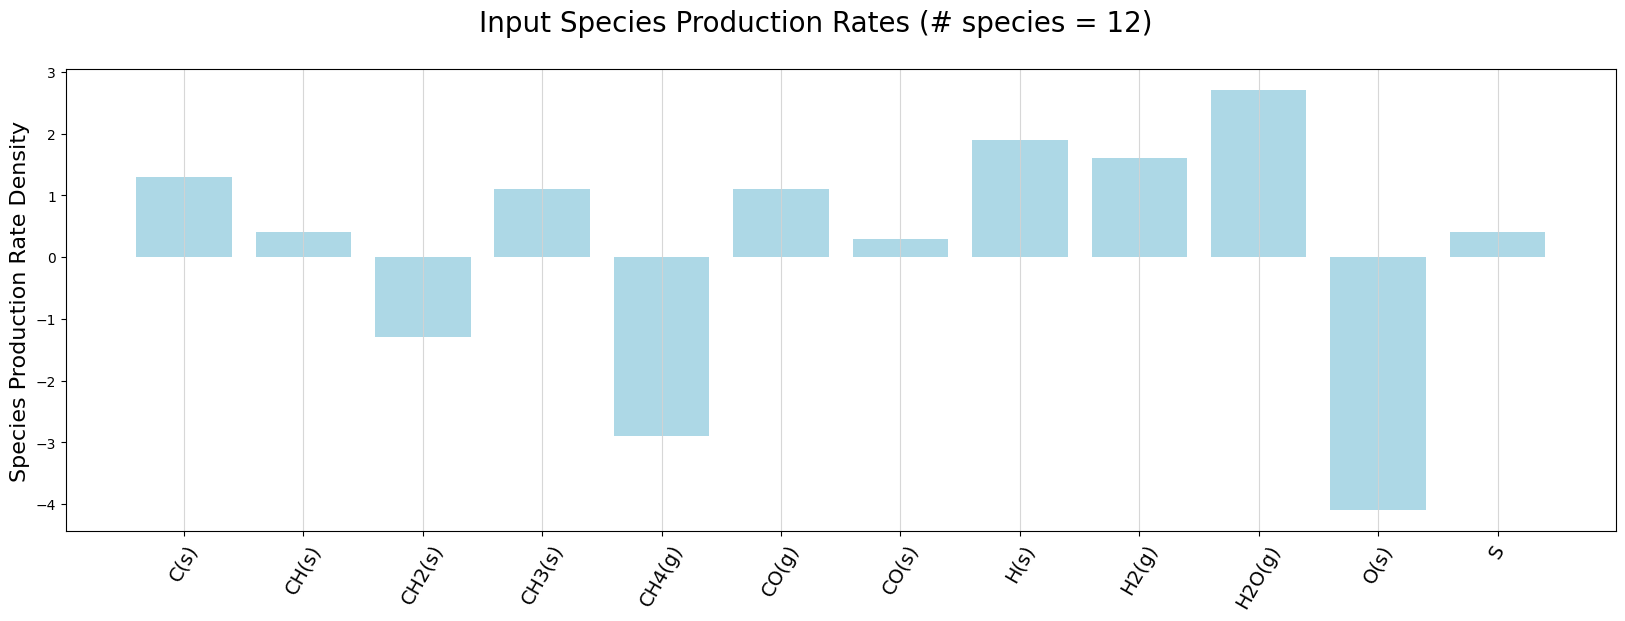

species =  ['C(s)', 'CH(s)', 'CH2(s)', 'CH3(s)', 'CH4(g)', 'CO(g)', 'CO(s)', 'H(s)', 'H2(g)', 'H2O(g)', 'O(s)', 'S']
species production rates g_vec = [ 1.3  0.4 -1.3  1.1 -2.9  1.1  0.3  1.9  1.6  2.7 -4.1  0.4]


In [11]:
'''Plot of the input species production rate'''

try: 
    from chen_3170.toolkit import plot_rates   
except ModuleNotFoundError:
    assert False, 'You need to provide your plot_rates function here. Bailing out.'
%matplotlib inline
plot_rates(species, g_vec, 
           title='Input Species Production Rates (# species = '+str(len(species))+')', 
           y_label='Species Production Rate Density', 
           x_tick_rotation=60, bar_color='lightblue', style='default')

print('species = ',species)
print('species production rates g_vec =',g_vec)

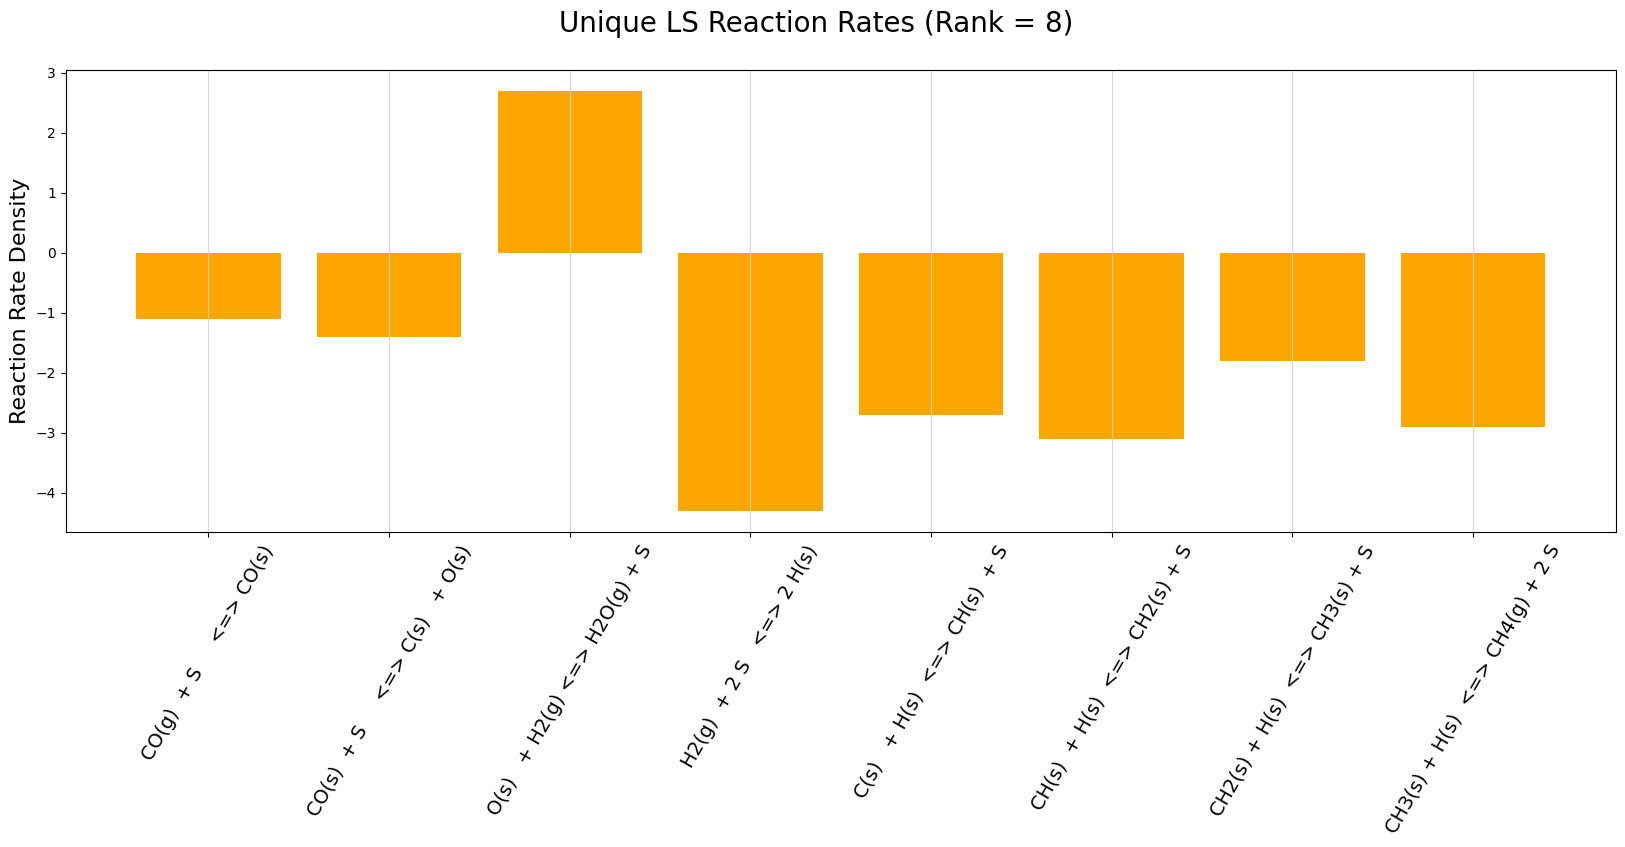

reaction rates r_vec = [-1.1 -1.4  2.7 -4.3 -2.7 -3.1 -1.8 -2.9]


In [12]:
'''Plot least-squares reaction rates'''

try: 
    from chen_3170.toolkit import plot_rates   
except ModuleNotFoundError:
    assert False, 'You need to provide your plot_rates function here. Bailing out.'
%matplotlib inline   
plot_rates(reactions, r_vec, 
           title='Unique LS Reaction Rates (Rank = %s)'%str(s_rank), 
           y_label='Reaction Rate Density', 
           x_tick_rotation=60, bar_color='orange', style='default')

print('reaction rates r_vec =',r_vec)